We use tiingo api to get stock prices data.
Please register tiingo to get a api key.

In [59]:
# settings.py
from dotenv import load_dotenv
load_dotenv()

# OR, the same with increased verbosity:
load_dotenv(verbose=True)

# OR, explicitly providing path to '.env'
from pathlib import Path  # python3 only
env_path = Path('D:\python_code\deep_learning_in_python\stock\numeric\custom_loss_dl_data_from_tiingo') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [60]:
# settings.py
import os
TIINGO_API_KEY = os.getenv("TIINGO_API_KEY")

使用TCN加上custom loss function，預測5營業日後收盤價，
使用RUA實測，使用TCN加上custom loss function與使用TCN, loss func使用MSE比較，為了減少Random seed的影響，將每個參數組合跑10次後，平均，做出來的結果顯示TCN加上custom loss func後，報酬率平均比單純使用TCN，MSE作為損失函數好1~2%

set the stock related variable
如果平時使用，不要重新訓練，請將task_category設成0，要重新訓練模型請設成1
checkpoint_name是目前weight存檔的名稱，可以在重train模型時設成其他名稱
ticker是股票代號(tiingo上有的都可以用，基本上美股居多)

In [62]:
ticker="VTI"
startDate="1990-01-01"
EndDate="2019-12-15"
task_category=0
checkpoint_name='2019_1215'

set model parameter

In [ ]:
val_split_ratio = 0.1
#My experiment set neurons in (32,128,512)
neurons=[32]
#you could set penalty in (0.01,0.1,1,10,100)
penalties=[0.1]

end of setting variable

In [63]:
import requests
headers = {
    'Content-Type': 'application/json'
}
requestResponse = requests.get(
    "https://api.tiingo.com/tiingo/daily/"+ticker+"/prices?startDate="+startDate+"&endDate="+EndDate+"&token="+TIINGO_API_KEY, headers=headers)


In [64]:
import json
from pandas.io.json import json_normalize
import pandas as pd
from datetime import datetime

In [65]:
jdata = json.loads(requestResponse.text)
df = pd.DataFrame(jdata)

df.columns

Index(['adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'adjVolume', 'close',
       'date', 'divCash', 'high', 'low', 'open', 'splitFactor', 'volume'],
      dtype='object')

In [66]:
df.drop(['high', 'low','open', 'adjVolume', 'close'], axis=1, inplace=True)

In [67]:
df['date'] = pd.to_datetime(df["date"])


In [68]:
df["only_date"] = df['date'].apply(lambda x:x.date())
df.drop(['date'], axis=1, inplace=True)


In [69]:
df.rename(columns={"only_date":"date"},inplace=True)


In [70]:
df_idx = df.set_index(["date"], drop=True)

In [71]:
import tensorflow as tf
print(tf.__version__)


2.0.0-dev20190213


In [72]:
print(tf.__file__ )

C:\Windows\system32\env002\lib\site-packages\tensorflow\__init__.py


# work: model  9 10

In [73]:
#tf.enable_eager_execution()

In [74]:
tf.executing_eagerly()


True

In [75]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pydot_ng
%matplotlib inline

In [76]:
import mpld3
mpld3.enable_notebook()

In [77]:
#把順序調換
df_idx = df_idx.sort_index(axis=0, ascending=False)
df_idx = df_idx.iloc[::-1]

In [78]:
df_idx.head(5)

,adjClose,adjHigh,adjLow,adjOpen,divCash,splitFactor,volume
date,,,,,,,
1993-01-29,26.586114,26.604993,26.472660,26.604993,0.0,1.0,1003200
1993-02-01,26.775204,26.775204,26.604993,26.604993,0.0,1.0,480500
1993-02-02,26.831901,26.850841,26.699568,26.756265,0.0,1.0,201300
1993-02-03,27.115567,27.134446,26.850841,26.869719,0.0,1.0,529400
1993-02-04,27.229021,27.285718,26.907537,27.210082,0.0,1.0,531500


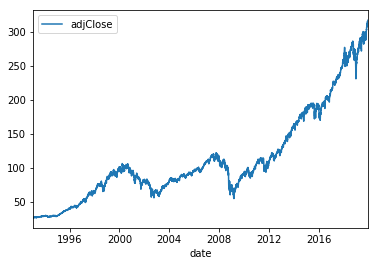

In [79]:
data = df_idx
data.plot(y='adjClose')

In [80]:
data.index.values[:5]

array([datetime.date(1993, 1, 29), datetime.date(1993, 2, 1),
       datetime.date(1993, 2, 2), datetime.date(1993, 2, 3),
       datetime.date(1993, 2, 4)], dtype=object)

In [81]:
diff = data.index.values[-1] - data.index.values[0]
startDate = datetime.strptime(startDate,"%Y-%m-%d")


In [82]:
startyear=startDate.year

In [83]:
days = diff.days
years = int(days/365)
print("total data days:",days)
print("Total data: %d years"%years)
print("80 percent data = 1988 to %d"%(startyear + int(0.8*years)))
print("80 percent data = 1988 to {}".format(startyear + int(0.8*years)))
print(diff)
delay = 5

#convert to years old method
"""
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
"""

total data days: 9814
Total data: 26 years
80 percent data = 1988 to 2010
80 percent data = 1988 to 2010
9814 days, 0:00:00


"\ndays = diff.astype('timedelta64[D]')\ndays = days / np.timedelta64(1, 'D')\nyears = int(days/365)\n"

In [84]:
#切割訓練與測試資料
split_date = pd.Timestamp('01-01-{}'.format(startyear + int(0.8*years)+1))
split_date=split_date.date()

In [85]:
train = data.loc[:split_date]
test = data.loc[split_date:]
test_date = test.index
test_date = pd.to_datetime(test_date)
train_date = train.index
train_date = pd.to_datetime(train_date)

In [86]:
# 資料正規化

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

C:\Windows\system32\env002\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [87]:
#without sc
#train_sc = train
#test_sc = test

In [88]:
train_sc.shape

(4516, 7)

In [89]:
train_sc_df = pd.DataFrame(train_sc,index=train.index,columns=train.columns)
test_sc_df = pd.DataFrame(test_sc,index=test.index,columns=test.columns)



In [90]:
train_sc_df

,adjClose,adjHigh,adjLow,adjOpen,divCash,splitFactor,volume
date,,,,,,,
1993-01-29,0.003350,0.002738,0.005941,0.003534,0.000000,0.0,0.001146
1993-02-01,0.005321,0.004498,0.007327,0.003534,0.000000,0.0,0.000546
1993-02-02,0.005912,0.005280,0.008318,0.005105,0.000000,0.0,0.000225
1993-02-03,0.008868,0.008214,0.009902,0.006283,0.000000,0.0,0.000602
1993-02-04,0.010050,0.009778,0.010496,0.009817,0.000000,0.0,0.000604
1993-02-05,0.009853,0.009583,0.012080,0.009817,0.000000,0.0,0.000559
1993-02-08,0.009853,0.009974,0.013269,0.009817,0.000000,0.0,0.000679
1993-02-09,0.007882,0.008018,0.011090,0.008836,0.000000,0.0,0.000134
1993-02-10,0.008277,0.007627,0.010892,0.007854,0.000000,0.0,0.000430


In [91]:
test_sc_df

,adjClose,adjHigh,adjLow,adjOpen,divCash,splitFactor,volume
date,,,,,,,
2011-01-03,0.836822,0.834436,0.832902,0.830807,0.0,0.0,0.159038
2011-01-04,0.836211,0.832440,0.837206,0.836207,0.0,0.0,0.157668
2011-01-05,0.841980,0.835477,0.839578,0.829675,0.0,0.0,0.153706
2011-01-06,0.839794,0.836431,0.844410,0.839342,0.0,0.0,0.140545
2011-01-07,0.837609,0.835910,0.836855,0.838210,0.0,0.0,0.179083
2011-01-10,0.836211,0.830619,0.837294,0.829675,0.0,0.0,0.140314
2011-01-11,0.840144,0.835650,0.843883,0.837165,0.0,0.0,0.126517
2011-01-12,0.850196,0.844151,0.848363,0.843871,0.0,0.0,0.123258
2011-01-13,0.848360,0.843891,0.853546,0.847529,0.0,0.0,0.148096


In [92]:
for s in range(-delay,-delay+1):
    train_sc_df['Y_{}'.format(s)] = train_sc_df['adjClose'].shift(s)
    test_sc_df['Y_{}'.format(s)] = test_sc_df['adjClose'].shift(s)



In [93]:
train_sc_df

,adjClose,adjHigh,adjLow,adjOpen,divCash,splitFactor,volume,Y_-5
date,,,,,,,,
1993-01-29,0.003350,0.002738,0.005941,0.003534,0.000000,0.0,0.001146,0.009853
1993-02-01,0.005321,0.004498,0.007327,0.003534,0.000000,0.0,0.000546,0.009853
1993-02-02,0.005912,0.005280,0.008318,0.005105,0.000000,0.0,0.000225,0.007882
1993-02-03,0.008868,0.008214,0.009902,0.006283,0.000000,0.0,0.000602,0.008277
1993-02-04,0.010050,0.009778,0.010496,0.009817,0.000000,0.0,0.000604,0.009656
1993-02-05,0.009853,0.009583,0.012080,0.009817,0.000000,0.0,0.000559,0.007488
1993-02-08,0.009853,0.009974,0.013269,0.009817,0.000000,0.0,0.000679,0.000394
1993-02-09,0.007882,0.008018,0.011090,0.008836,0.000000,0.0,0.000134,0.000197
1993-02-10,0.008277,0.007627,0.010892,0.007854,0.000000,0.0,0.000430,0.000000


In [94]:
test_sc_df

,adjClose,adjHigh,adjLow,adjOpen,divCash,splitFactor,volume,Y_-5
date,,,,,,,,
2011-01-03,0.836822,0.834436,0.832902,0.830807,0.0,0.0,0.159038,0.836211
2011-01-04,0.836211,0.832440,0.837206,0.836207,0.0,0.0,0.157668,0.840144
2011-01-05,0.841980,0.835477,0.839578,0.829675,0.0,0.0,0.153706,0.850196
2011-01-06,0.839794,0.836431,0.844410,0.839342,0.0,0.0,0.140545,0.848360
2011-01-07,0.837609,0.835910,0.836855,0.838210,0.0,0.0,0.179083,0.856490
2011-01-10,0.836211,0.830619,0.837294,0.829675,0.0,0.0,0.140314,0.858413
2011-01-11,0.840144,0.835650,0.843883,0.837165,0.0,0.0,0.126517,0.847312
2011-01-12,0.850196,0.844151,0.848363,0.843871,0.0,0.0,0.123258,0.845826
2011-01-13,0.848360,0.843891,0.853546,0.847529,0.0,0.0,0.148096,0.848360


In [95]:
#X_train = train_sc_df.dropna().drop('Y', axis=1)
X_train = train_sc_df.dropna().drop('Y_-'+str(delay), axis=1)
y_train = train_sc_df.dropna()['Y_-'+str(delay)]
X_train = X_train.as_matrix()
y_train = y_train.as_matrix()


C:\Windows\system32\env002\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Windows\system32\env002\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [96]:
X_train

array([[3.35035124e-03, 2.73783434e-03, 5.94133131e-03, ...,
        0.00000000e+00, 0.00000000e+00, 1.14600312e-03],
       [5.32096061e-03, 4.49818360e-03, 7.32732508e-03, ...,
        0.00000000e+00, 0.00000000e+00, 5.45786857e-04],
       [5.91182813e-03, 5.28042198e-03, 8.31786384e-03, ...,
        0.00000000e+00, 0.00000000e+00, 2.25181575e-04],
       ...,
       [8.22312389e-01, 8.15959175e-01, 8.25610708e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.08908835e-01],
       [8.25721365e-01, 8.18995205e-01, 8.30354386e-01, ...,
        0.00000000e+00, 0.00000000e+00, 9.05039498e-02],
       [8.24147992e-01, 8.18648230e-01, 8.29300235e-01, ...,
        0.00000000e+00, 0.00000000e+00, 8.04349011e-02]])

In [97]:
X_train.shape

(4511, 7)

In [98]:
y_train.shape

(4511,)

In [99]:
X_test = test_sc_df.dropna().drop('Y_-'+str(delay), axis=1)
y_test = test_sc_df.dropna().dropna()['Y_-'+str(delay)]
X_test = X_test.as_matrix()
y_test = y_test.as_matrix()


C:\Windows\system32\env002\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Windows\system32\env002\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [100]:
y_train

array([0.00985305, 0.00985305, 0.00788244, ..., 0.8269451 , 0.82519691,
       0.82545914])

In [101]:
X_test

array([[0.83682239, 0.83443559, 0.83290192, ..., 0.        , 0.        ,
        0.15903785],
       [0.83621052, 0.83244048, 0.83720636, ..., 0.        , 0.        ,
        0.15766766],
       [0.84197956, 0.83547651, 0.8395782 , ..., 0.        , 0.        ,
        0.15370589],
       ...,
       [2.97216882, 2.95556841, 2.97882424, ..., 0.        , 0.        ,
        0.05626986],
       [2.97800487, 2.95691289, 2.98154736, ..., 0.        , 0.        ,
        0.0466805 ],
       [3.0077062 , 2.98855978, 3.01851891, ..., 0.        , 0.        ,
        0.05617588]])

In [102]:
y_test

array([0.83621052, 0.84014396, 0.85019607, ..., 3.00301652, 3.03125883,
       3.03323892])

In [103]:
print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))

Train size: (4511 x 7)
Test size: (2248 x 7)


# setup

In [104]:
loss_imagepath ='images/loss/'
predict_and_imagepath ='images/predict/'
losspath = 'csv/loss/'
if (not (os.path.exists(losspath))):
        os.makedirs(losspath)
file_name='file_name'

#for func initiate
history_model='history_model'
input_tensor='input_tensor'
y_pred='y_pred'
Target_DirPath='Target_DirPath'
test_date_trim='test_date_trim'
train_date_trim='train_date_trim'


In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Add,Reshape,Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow.keras.backend as K
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping,CSVLogger
from tensorflow.keras.layers import LSTM
from tensorflow.keras import Input,layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import PReLU
from tensorflow.keras.utils import plot_model
K.clear_session()
#from tcn import compiled_tcn,TCN

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])




In [106]:
def plot_model_architecture(model, file_name):
    file_path = 'images/model/{}.png'.format(file_name)
    if not os.path.exists(os.path.dirname(file_path)):
        try:
            os.makedirs(os.path.dirname(file_path))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

    plot_model(model, to_file=file_path, show_shapes=True, show_layer_names=False)

In [107]:
def loadmodel(model_dirpath=model_dirpath,file_name=file_name):
    model = load_model(model_dirpath + file_name + '.h5')
    return model
def loss_image(history_model=history_model, loss_imagepath=loss_imagepath, file_name=file_name):
    import matplotlib.pyplot as plt
    loss = history_model.history['loss']
    val_loss = history_model.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if (not (os.path.exists(loss_imagepath))):
                os.makedirs(loss_imagepath)
    plt.savefig(loss_imagepath +  file_name +'_loss.png')
    plt.show()    

def CSV(losspath=losspath, file_name=file_name):
    csv_logger = CSVLogger(losspath + file_name + '_log.csv')
    return csv_logger
def predict_and_image(history_model=history_model,X_tst_t=X_tst_t,input_tensor=input_tensor,
                  predict_and_imagepath=predict_and_imagepath, file_name=file_name):
    from sklearn.metrics import r2_score
    y_pred = model.predict([X_tst_t])
    #y_pred是三天前就知道，所以往前移三格
    y_test_pic = y_test[:]
    y_pred_pic = y_pred[delay:]
    y_test_rsquare = y_test[:]
    plt.plot(y_test_pic, label='True')
    plt.plot(y_pred_pic, label='pred')
    plt.xlabel('Observation')
    plt.ylabel('Scaled_Value')
    plt.legend()
    print("y_pred.shape:",y_pred.shape)
    print("y_test_rsquare.shape:",y_test_rsquare.shape)
    r2_test = r2_score(y_test_rsquare, y_pred)
    print('R-Squared: %f'%(r2_test))
    print("The Adjusted R2 score on the Test set is:\t{:0.3f}"\
          .format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
    if (not (os.path.exists(predict_and_imagepath))):
            os.makedirs(predict_and_imagepath)
    plt.savefig(predict_and_imagepath +  file_name +'_loss.png')
    plt.show()    
    return y_pred
def save_csv(y_pred=y_pred,X_train=X_train,X_test=X_test,Target_DirPath=Target_DirPath,\
             file_name=file_name,test_date=test_date):
    # 把價格縮放解除
    ## create empty table with label fields
    y_pred_data_like = np.zeros(shape=(len(y_pred), X_train.shape[1]))
    ## put the predicted values in the right field
    y_pred_data_like[:,0] = y_pred[:,0]
    ## inverse transform and then select the right field
    y_pred_data = sc.inverse_transform(y_pred_data_like)[:,0]

    #檢查測試資料的維度
    yd_size = X_test.shape[0]

    # 把價格轉換維度
    yd = y_pred_data.reshape(yd_size,)

    #把最後X天刪除(預測X天後)
    test_date_trim = np.delete(test_date, np.s_[-delay:])

    # 製作CSV
    AnalysisResult = pd.DataFrame()
    Date = pd.Series(test_date_trim)
    Close = pd.Series(yd)
    Date.name = 'Date'
    Close.name = 'Close'

    # 因為放在MC要開高低收，所以複製收盤填入
    Open = Close.copy()
    High = Close.copy()
    Low = Close.copy()
    Open.name = 'Open'
    High.name = 'High'
    Low.name = 'Low'

    AnalysisResult = pd.concat([AnalysisResult,Date], axis=1)
    AnalysisResult = pd.concat([AnalysisResult,Close], axis=1)
    AnalysisResult = pd.concat([AnalysisResult,Open], axis=1)
    AnalysisResult = pd.concat([AnalysisResult,High], axis=1)
    AnalysisResult = pd.concat([AnalysisResult,Low], axis=1)
    
    print("last row，the price is five days after the row date:\n")
    print(df.iloc[[-1]])
    # 輸出CSV檔案
    import os
    Target_DirPath = 'Deep-Learning-in-Python-master/'
    if (not (os.path.exists(Target_DirPath))):
            os.makedirs(Target_DirPath)
    AnalysisResult.to_csv(Target_DirPath + file_name+'.csv', mode='w', header=True, index=False)
    
def save_train_csv(file_name=file_name):
    y_train_pred = model.predict([X_tr_t])
    # 把價格縮放解除
    ## create empty table with label fields
    y_train_pred_data_like = np.zeros(shape=(len(y_train_pred), X_train.shape[1]))
    ## put the predicted values in the right field
    y_train_pred_data_like[:,0] = y_train_pred[:,0]
    ## inverse transform and then select the right field
    y_train_pred_data = sc.inverse_transform(y_train_pred_data_like)[:,0]

    #檢查測試資料的維度
    yd_size = X_train.shape[0]

    # 把價格轉換維度
    yd = y_train_pred_data.reshape(yd_size,)

    #把最後X天刪除(預測X天後)
    train_date_trim = np.delete(train_date, np.s_[-delay:])

    # 製作CSV
    AnalysisResult = pd.DataFrame()
    Date = pd.Series(train_date_trim)
    Close = pd.Series(yd)
    Date.name = 'Date'
    Close.name = 'Close'

    # 因為放在MC要開高低收，所以複製收盤填入
    Open = Close.copy()
    High = Close.copy()
    Low = Close.copy()
    Open.name = 'Open'
    High.name = 'High'
    Low.name = 'Low'

    AnalysisResult = pd.concat([AnalysisResult,Date], axis=1)
    AnalysisResult = pd.concat([AnalysisResult,Close], axis=1)
    AnalysisResult = pd.concat([AnalysisResult,Open], axis=1)
    AnalysisResult = pd.concat([AnalysisResult,High], axis=1)
    AnalysisResult = pd.concat([AnalysisResult,Low], axis=1)

    # 輸出CSV檔案
    import os
    Target_DirPath = 'Deep-Learning-in-Python-master-train/'
    if (not (os.path.exists(Target_DirPath))):
            os.makedirs(Target_DirPath)
    AnalysisResult.to_csv(Target_DirPath + file_name+'_train.csv', mode='w', header=True, index=False)    

# tcn

In [108]:
act_of_skip_connections='selu'
import tensorflow.keras.backend as K
import tensorflow.keras.layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.keras.layers import Conv1D, SpatialDropout1D
from tensorflow.keras.layers import Convolution1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Input

from typing import List, Tuple


def channel_normalization(x):
    # type: (Layer) -> Layer
    """ Normalize a layer to the maximum activation

    This keeps a layers values between zero and one.
    It helps with relu's unbounded activation

    Args:
        x: The layer to normalize

    Returns:
        A maximal normalized layer
    """
    max_values = K.max(K.abs(x), 2, keepdims=True) + 1e-5
    out = x / max_values
    return out


def wave_net_activation(x):
    # type: (Layer) -> Layer
    """This method defines the activation used for WaveNet

    described in https://deepmind.com/blog/wavenet-generative-model-raw-audio/

    Args:
        x: The layer we want to apply the activation to

    Returns:
        A new layer with the wavenet activation applied
    """
    tanh_out = Activation('tanh')(x)
    sigm_out = Activation('sigmoid')(x)
    return tensorflow.keras.layers.multiply([tanh_out, sigm_out])


def residual_block(x, s, i, activation, nb_filters, kernel_size, padding, dropout_rate=0, name=''):
    # type: (Layer, int, int, str, int, int, str, float, str) -> Tuple[Layer, Layer]
    """Defines the residual block for the WaveNet TCN

    Args:
        x: The previous layer in the model
        s: The stack index i.e. which stack in the overall TCN
        i: The dilation power of 2 we are using for this residual block
        activation: The name of the type of activation to use
        nb_filters: The number of convolutional filters to use in this block
        kernel_size: The size of the convolutional kernel
        padding: The padding used in the convolutional layers, 'same' or 'causal'.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        name: Name of the model. Useful when having multiple TCN.

    Returns:
        A tuple where the first element is the residual model layer, and the second
        is the skip connection.
    """

    original_x = x
    conv = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding=padding,
                  name=name + '_d_%s_conv_%d_tanh_s%d' % (padding, i, s))(x)
    if activation == 'norm_relu':
        x = Activation('relu')(conv)
        x = Lambda(channel_normalization)(x)
    elif activation == 'wavenet':
        x = wave_net_activation(conv)
    else:
        x = Activation(activation)(conv)

    x = SpatialDropout1D(dropout_rate, name=name + '_spatial_dropout1d_%d_s%d_%f' % (i, s, dropout_rate))(x)

    # 1x1 conv.
    x = Convolution1D(nb_filters, 1, padding='same')(x)
    res_x = tensorflow.keras.layers.add([original_x, x])
    return res_x, x


def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        # print(f'Updated dilations from {dilations} to {new_dilations} because of backwards compatibility.')
        return new_dilations


class TCN:
    """Creates a TCN layer.

        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).

        Args:
            nb_filters: The number of filters to use in the convolutional layers.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            activation: The activations to use (norm_relu, wavenet, relu...).
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            name: Name of the model. Useful when having multiple TCN.

        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=[1, 2, 4, 8, 16],
                 activation='norm_relu',
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=True,
                 name='tcn'):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.activation = activation
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.padding = padding

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

        if not isinstance(nb_filters, int):
            print('An interface change occurred after the version 2.1.2.')
            print('Before: tcn.TCN(i, return_sequences=False, ...)')
            print('Now should be: tcn.TCN(return_sequences=False, ...)(i)')
            print('Second solution is to pip install keras-tcn==2.1.2 to downgrade.')
            raise Exception()

    def __call__(self, inputs, Activation_of_skip_connections='selu'):
        x = inputs
        x = Convolution1D(self.nb_filters, 1, padding=self.padding, name=self.name + '_initial_conv')(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for i in self.dilations:
                x, skip_out = residual_block(x, s, i, self.activation, self.nb_filters,
                                             self.kernel_size, self.padding, self.dropout_rate, name=self.name)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = tensorflow.keras.layers.add(skip_connections)
        x = Activation(Activation_of_skip_connections)(x)

        if not self.return_sequences:
            output_slice_index = -1
            x = Lambda(lambda tt: tt[:, output_slice_index, :])(x)
        return x


def compiled_tcn(num_feat,  # type: int
                 num_classes,  # type: int
                 nb_filters,  # type: int
                 kernel_size,  # type: int
                 dilations,  # type: List[int]
                 nb_stacks,  # type: int
                 max_len,  # type: int
                 activation='norm_relu',  # type: str
                 padding='causal',  # type: str
                 use_skip_connections=True,  # type: bool
                 return_sequences=True,
                 regression=False,  # type: bool
                 dropout_rate=0.05,  # type: float
                 name='tcn'  # type: str
                 ):
    # type: (...) -> tensorflow.keras.Model
    """Creates a compiled TCN model for a given task (i.e. regression or classification).

    Args:
        num_feat: The number of features of your input, i.e. the last dimension of: (batch_size, timesteps, input_dim).
        num_classes: The size of the final dense layer, how many classes we are predicting.
        nb_filters: The number of filters to use in the convolutional layers.
        kernel_size: The size of the kernel to use in each convolutional layer.
        dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
        nb_stacks : The number of stacks of residual blocks to use.
        max_len: The maximum sequence length, use None if the sequence length is dynamic.
        activation: The activations to use.
        padding: The padding to use in the convolutional layers.
        use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
        return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
        regression: Whether the output should be continuous or discrete.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        name: Name of the model. Useful when having multiple TCN.

    Returns:
        A compiled keras TCN.
    """

    dilations = process_dilations(dilations)

    input_layer = Input(shape=(max_len, num_feat))

    x = TCN(nb_filters, kernel_size, nb_stacks, dilations, activation,
            padding, use_skip_connections, dropout_rate, return_sequences, name)(input_layer)

    print('x.shape=', x.shape)

    if not regression:
        # classification
        x = Dense(num_classes)(x)
        x = Activation('softmax')(x)
        output_layer = x
        print(f'model.x = {input_layer.shape}')
        print(f'model.y = {output_layer.shape}')
        model = Model(input_layer, output_layer)

        # https://github.com/keras-team/keras/pull/11373
        # It's now in Keras@master but still not available with pip.
        # TODO To remove later.
        def accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            if K.ndim(y_true) == K.ndim(y_pred):
                y_true = K.squeeze(y_true, -1)
            # convert dense predictions to labels
            y_pred_labels = K.argmax(y_pred, axis=-1)
            y_pred_labels = K.cast(y_pred_labels, K.floatx())
            return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

        adam = optimizers.Adam(lr=0.002, clipnorm=1.)
        model.compile(adam, loss='sparse_categorical_crossentropy', metrics=[accuracy])
        print('Adam with norm clipping.')
    else:
        # regression
        x = Dense(1)(x)
        x = Activation('linear')(x)
        output_layer = x
        print(f'model.x = {input_layer.shape}')
        print(f'model.y = {output_layer.shape}')
        model = Model(input_layer, output_layer)
        adam = optimizers.Adam(lr=0.002, clipnorm=1.)
        model.compile(adam, loss=tf_stock_loss_9)

    return model

# loss func

In [109]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

本模型input是股價，output是預測5營業日後的股價，
該模型除了用TCN外，另外使用Custom loss function，
該函數用mean square error修改而成，
如果第t期預測的股價-(t-1)期預測股價與t期實際的股價-(t-1)期實際股價符號相反，
也就是預測與實際變化方向不同，
就表示預測的股價變化方向失準，loss要給懲罰項

In [110]:
def tf_stock_loss_9(y_true, y_pred):

    indices = tf.constant([[-1],[-2],[-3],[-4],[-5]])
    updates = tf.cast(tf.constant([0,0,0,0,0]),tf.float32)
    """由於keras在計算loss時shape[-1]受batch size影響，
    但是我們比較的單位是t期股價-(t-1)期股價，
    要把每個batch用reshape從前到後接起來，
    才能整串全部一起比較差異
    例子如下:
    假設batch是3，
    train時y_pred和y_true會用以下方式排列
    y_pred=         [[t0 t1 t2]]
                    [[t3 t4 t5]]
                    [[t6 t7 t8]]
    用tf.roll往前推五個，理論上要用以下方式排列，才能與y_pred_previous相減
    roll後的y_pred=         [[t5 t6 t7]]
                            [[t8 t0 t1]]
                            [[t2 t3 t4]]
           y_pred_previous =[[t0 t1 t2]]
                            [[t3 t4 t5]]
                            [[t6 t7 t8]]
    如果y_pred減y_pred_previous大於0，表示該時點預測股價上升，
    但是實際上tf.roll會變成以下情況
    y_pred=         [[t2 t0 t1]]
                    [[t5 t3 t4]]
                    [[t8 t6 t7]]
    也就是roll只roll最後一個維度，
    所以要reshape成[-1]再使用tf.roll
    變成
    y_pred_previous=[[t0 t1 t2 t3 t4 t5 t6 t7 t8]]
    y_pred=         [[t5 t6 t7 t8 t0 t1 t2 t3 t4]] 
    再使用K.less判斷相減是否大於0
    但是有一點要注意的是，tensor中最後五個，y_pred變成t0 t1 t2 t3 t4，
    也就是roll在時點最前面的反而變成最後面，此時y_pred和y_pred_previous相減無意義，
    所以把y_pred和y_pred_previous最後五個都取0，不做判斷
    """
    y_pred_tobemodified0 = tf.reshape(y_pred, [-1])
    y_pred_tobemodified1 = tf.roll(y_pred_tobemodified0, shift=-5, axis=0)
    y_pred_previous_cl = tf.tensor_scatter_update(y_pred_tobemodified0, indices, updates)
    y_pred_cl = tf.tensor_scatter_update(y_pred_tobemodified1, indices, updates)
    y_pred_previous = tf.reshape(y_pred_previous_cl,tf.shape(y_pred))
    y_pred_dummy = tf.reshape(y_pred_cl,tf.shape(y_pred))
    
    #如果y_pred_previous比y_pred_dummy少，回傳True，表示預測股價上升
    y_pred_rising = K.less(y_pred_previous, y_pred_dummy)
    y_pred_falling = K.greater(y_pred_previous, y_pred_dummy)    


    y_true_tobemodified0 = tf.reshape(y_true, [-1])
    y_true_tobemodified1 = tf.roll(y_true_tobemodified0, shift=-5, axis=0)
    y_true_previous_cl = tf.tensor_scatter_update(y_pred_tobemodified0, indices, updates)
    y_true_cl = tf.tensor_scatter_update(y_true_tobemodified1, indices, updates)
    y_true_previous = tf.reshape(y_true_previous_cl,tf.shape(y_true))
    y_true_dummy = tf.reshape(y_true_cl,tf.shape(y_true))
    
    y_true_rising = K.less(y_true_previous, y_true_dummy)
    y_true_falling = K.greater(y_true_previous, y_true_dummy)  

    loss = tf.keras.backend.cast(tf.logical_and(y_true_falling,y_pred_rising),dtype='float32')*penalty* mean_squared_error(y_true, y_pred)+\
             tf.keras.backend.cast(tf.logical_and(y_true_rising,y_pred_falling),dtype='float32')*penalty*mean_squared_error(y_true, y_pred)+\
             mean_squared_error(y_true, y_pred)       

    return loss

In [111]:

losses = tf_stock_loss_9
for neurons_j in neurons:
    for penalty_i in penalties:
        if penalty_i == 'x':
            losses = 'mse'
        else:
            losses = tf_stock_loss_9
            penalty = penalty_i
        file_name='RUA_de5_tcn_clf9_n'+str(neurons_j)+'_pe'+str(penalty_i)

        X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

        input_tensor= Input(shape=(1,X_train.shape[1],))
        output = TCN(nb_filters=neurons_j, kernel_size=2, nb_stacks=1, dilations=[1, 2, 4, 8, 16], \
                activation='selu', padding='causal', use_skip_connections=True,\
                dropout_rate=0.3, return_sequences=False, name='tcn')(input_tensor)  # The TCN layers are here.

        output_tensor = Dense(1)(output)
        model = Model([input_tensor], output_tensor)
        model.compile(optimizer=Adam(lr=0.0001, clipnorm=1, clipvalue=0.5), loss=losses)
        model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 7)]       0                                            
__________________________________________________________________________________________________
tcn_initial_conv (Conv1D)       (None, 1, 32)        256         input_1[0][0]                    
__________________________________________________________________________________________________
tcn_d_causal_conv_1_tanh_s0 (Co (None, 1, 32)        2080        tcn_initial_conv[0][0]           
__________________________________________________________________________________________________
activation (Activation)         (None, 1, 32)        0           tcn_d_causal_conv_1_tanh_s0[0][0]
______________________________________________________________________________________________

don't set task_category=1 if you don't want to train model again.
We only compile the model and load the model weight when we predict the stock prices everyday.
That is, we use our model weight that we trained before.


In [ ]:
if task_category=1:
    early_stop = EarlyStopping(monitor='loss', patience=20, verbose=0)
    history_model = model.fit(x=[X_tr_t], y=y_train, epochs=300,
                                        batch_size=32, verbose=1,
                                        validation_split= val_split_ratio,
                                        shuffle=False)
    plot_model_architecture(model=model, file_name=file_name)
    y_pred = predict_and_image(history_model=history_model,X_tst_t=X_tst_t,input_tensor=input_tensor,          
                      predict_and_imagepath=predict_and_imagepath, file_name=file_name)
    loss_image(history_model=history_model, loss_imagepath=loss_imagepath, file_name=file_name)
    save_csv(y_pred=y_pred,X_train=X_train,X_test=X_test,Target_DirPath=Target_DirPath,
                 file_name=file_name,test_date=test_date)
    save_train_csv(file_name=file_name)
    print(file_name+":")

In [ ]:
# Save the weights
if task_category=1:
    model.save_weights('./checkpoints/'+checkpoint_name)

In [112]:
# Restore the weights
model.load_weights('./checkpoints/'+checkpoint_name)
#load the model weight to predict new stock prices

y_pred.shape: (2248, 1)
y_test_rsquare.shape: (2248,)
R-Squared: -0.843640
The Adjusted R2 score on the Test set is:	-0.849


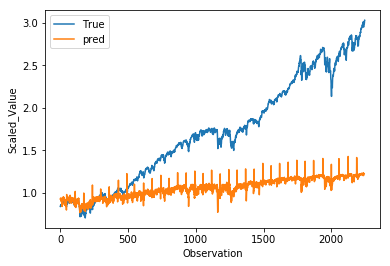

In [113]:
y_pred = predict_and_image(history_model=history_model,X_tst_t=X_tst_t,input_tensor=input_tensor,          
                          predict_and_imagepath=predict_and_imagepath, file_name=file_name)